In [29]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression # 선형회귀
from sklearn.linear_model import Ridge, Lasso # 릿지 라쏘

# 앙상블
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer
import calendar

- 문제 이해
- 평가 지표 파악 왜 RMSLE를 쓰는가
- RMSLE 는 예측값과 실제값 사이의 상대적인 오차를 측정

- 즉, 예측값과 실제값 사이의 비율을 중요시
    - 이는 큰 값에 대한 예측이 작은 값에 대한 예측보다 더 많은 오차를 가지더라도, 그 차이가 상대적으로 작다
    - 따라서 예측값과 실제값의 비율이 중요한 상황에서 RMSLE 를 사용
- RMSLE 는 오차가 크게 발생했을 때 그에 대해 더 관대한 경향이 잇음
- 예측값이 실제값보다 매우 크거나 작은 경우에도 오차의 절대적인 크기가 아닌 상대적인 크기를 고려하기 때문에, 모델의 성능을 과대평가할 위험이 있음

In [167]:
def rmsle(y_true, y_pred, convert_exp):
    '''
    실제 타깃값과 예측값을 인수로 전달하면 RMSLE 수치를 반환하는 함수
    convert_exp : 입력 데이터를 지수변환할지 정하는 파라미터
    타깃값으로 log(count)를 사용한 경우에는 지수변환을 해줘야함
    '''
    # 지수변환
    if convert_exp:
        y_true = np.exp(y_true)
        y_pred = np.exp(y_pred)
        
    # 로그변환 후 결측값을 0으로 변환
    log_true = np.nan_to_num(np.log(y_true + 1))
    log_pred = np.nan_to_num(np.log(y_pred + 1))
    
    # RMSLE 계산
    output = np.sqrt(np.mean((log_true - log_pred)**2))
    
    return output

In [5]:
train_df = pd.read_csv("./data/bike/train.csv")
test_df = pd.read_csv("./data/bike/test.csv")
submission_df = pd.read_csv("./data/bike/sampleSubmission.csv")

In [9]:
train_df.head(1)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16


In [10]:
test_df.head(1)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027


In [11]:
train_df.shape, test_df.shape, submission_df.shape

((10886, 12), (6493, 9), (6493, 2))

In [13]:
train_df.dtypes

datetime       object
season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
casual          int64
registered      int64
count           int64
dtype: object

- datetime 은 날짜인데 object로 표현되어 전처리 필요함
- 날짜, 연도, 월,일,시,분,초로 각각 컬럼 생성

In [14]:
train_df.isna().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

# 데이터 분석

## datetime 구성요소별로 나누기

In [15]:
train_df["datetime"][0]

'2011-01-01 00:00:00'

In [16]:
train_df["datetime"][0].split()

['2011-01-01', '00:00:00']

In [17]:
train_df["datetime"][0].split()[1].split(":")

['00', '00', '00']

In [25]:
train_df["date"] = train_df["datetime"].str.split().str[0]
train_df["year"] = train_df["datetime"].str.split("-").str[0]
train_df["month"] = train_df["datetime"].str.split("-").str[1]
train_df["day"] = train_df["datetime"].str.split("-").str[2].str.split().str[0]

train_df["hour"] = train_df["datetime"].str.split().str[1].str.split(":").str[0]
train_df["minute"] = train_df["datetime"].str.split().str[1].str.split(":").str[1]
train_df["second"] = train_df["datetime"].str.split().str[1].str.split(":").str[2]

In [26]:
train_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date,year,month,day,hour,minute,second
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011-01-01,2011,01,01,00,00,00
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011-01-01,2011,01,01,01,00,00
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011-01-01,2011,01,01,02,00,00
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011-01-01,2011,01,01,03,00,00
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011-01-01,2011,01,01,04,00,00


In [30]:
calendar.day_name[pd.to_datetime(train_df["date"])[0].weekday()]

'Saturday'

In [34]:
train_df["weekday"] = train_df["date"].map(lambda x: calendar.day_name[pd.to_datetime(x).weekday()])

In [37]:
train_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date,year,month,day,hour,minute,second,weekday
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011-01-01,2011,01,01,00,00,00,Saturday
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011-01-01,2011,01,01,01,00,00,Saturday
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011-01-01,2011,01,01,02,00,00,Saturday
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011-01-01,2011,01,01,03,00,00,Saturday
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011-01-01,2011,01,01,04,00,00,Saturday


## season, weather 범주형 데이터 문자열로 변환

In [38]:
train_df["season"].unique()

array([1, 2, 3, 4])

In [39]:
train_df["season"] = train_df["season"].map(
    { 1 : "Spring",
        2 : "Summer",
        3 : "Fall",
        4 : "Winter",
    }
)

In [40]:
train_df["season"].unique()

array(['Spring', 'Summer', 'Fall', 'Winter'], dtype=object)

In [41]:
train_df["weather"].unique()

array([1, 2, 3, 4])

In [42]:
train_df["weather"] = train_df["weather"].map(
    { 
        1 : "Clear",
        2 : "Mist",
        3 : "Light Snow, Rain, Thunder",
        4 : "Heavy Snow, Rain, Thunder",
    }
)

In [43]:
train_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date,year,month,day,hour,minute,second,weekday
0,2011-01-01 00:00:00,Spring,0,0,Clear,9.84,14.395,81,0.0,3,13,16,2011-01-01,2011,01,01,00,00,00,Saturday
1,2011-01-01 01:00:00,Spring,0,0,Clear,9.02,13.635,80,0.0,8,32,40,2011-01-01,2011,01,01,01,00,00,Saturday
2,2011-01-01 02:00:00,Spring,0,0,Clear,9.02,13.635,80,0.0,5,27,32,2011-01-01,2011,01,01,02,00,00,Saturday
3,2011-01-01 03:00:00,Spring,0,0,Clear,9.84,14.395,75,0.0,3,10,13,2011-01-01,2011,01,01,03,00,00,Saturday
4,2011-01-01 04:00:00,Spring,0,0,Clear,9.84,14.395,75,0.0,0,1,1,2011-01-01,2011,01,01,04,00,00,Saturday


- 정리
    - date 컬럼의 정보는 year, month, day 에도 잇어서 제거하는 편이 더 나을 수 있음
    - month 컬럼은 세 달씩 묶으면 season 이 되기 때문에 연관성이 너무 높아서 제거하는 편이 더 나을 수 있음

## 데이터 시각화

### 종속변수 분포도

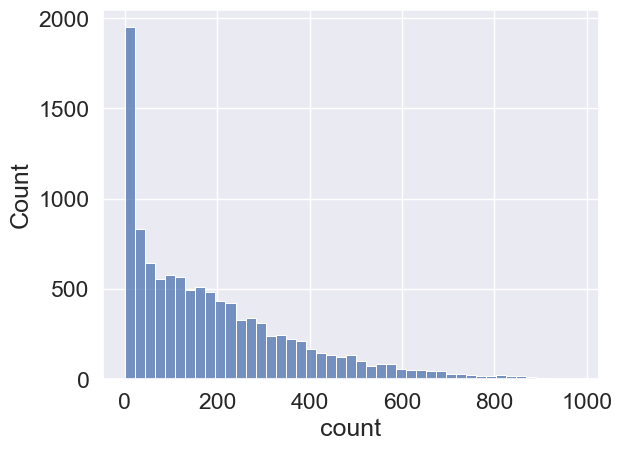

In [45]:
sns.set(font_scale = 1.5)
sns.histplot(train_df["count"])
plt.show()

- 종속변수의 분포가 종모양이 아니라서 선형회귀모델을 쓴 사람들은 평가지표가 영 아니였을 것이다!

- 회귀 모델이 좋은 성능을 내기 위해서는 데이터가 정규분포를 따르는 것이 좋은데 0 근처에 몰려있음

# 이럴때는 정규화! 로그변환!!!

<Axes: xlabel='count', ylabel='Count'>

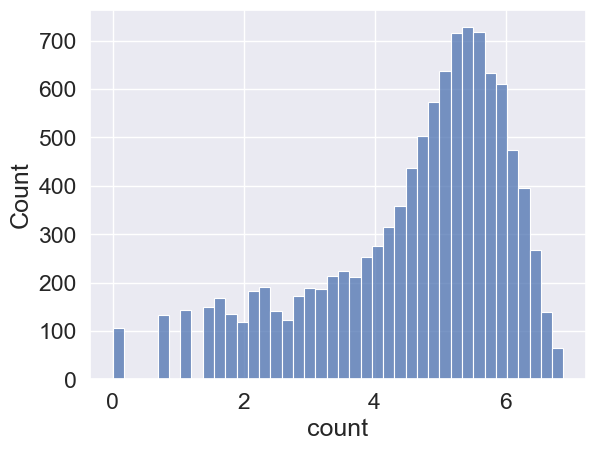

In [46]:
sns.histplot(np.log(train_df["count"]))

우와~~~!~!!!~!~!~!~!~!~! 우파다~!~!~!

- log 변환하면 큰 값은 더 많이 줄어들고 작은 값은 조금만 줄여서 전체 범위가 줄어듦

- count 로 예측하는 것보다 log(count)로 예측하는 것이 더 정확할 수 있음

- **log(count)로 예측하면 예측값에 지수 변환하여 실제값인 count 로 복원해야함ㅁ!#@!@!**

### **시간관련 컬럼과 종속변수관계**

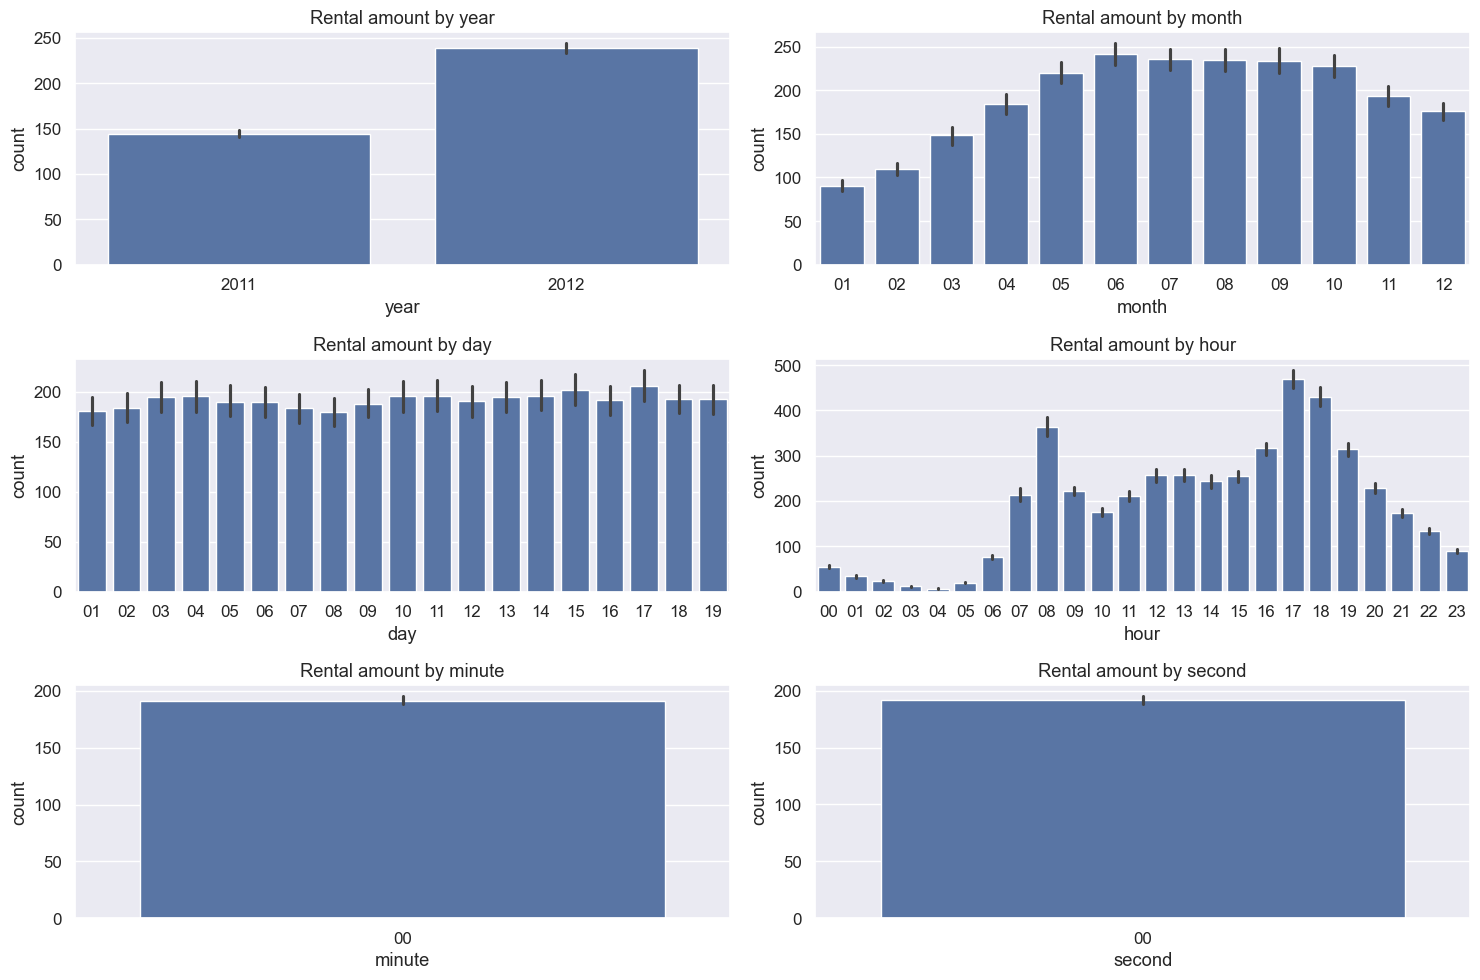

In [49]:
# Figure 준비
sns.set(font_scale = 1.1)
fig, axes = plt.subplots(nrows = 3, ncols = 2, figsize = (15, 10)) 

# 각 축에 연도, 월, 일, 시간, 분 초 별 평균 대여 수량 막대 그래프 할당
sns.barplot(x = "year", y = "count", data = train_df, ax = axes[0,0])
sns.barplot(x = "month", y = "count", data = train_df, ax = axes[0,1])
sns.barplot(x = "day", y = "count", data = train_df, ax = axes[1,0])

sns.barplot(x = "hour", y = "count", data = train_df, ax = axes[1,1])
sns.barplot(x = "minute", y = "count", data = train_df, ax = axes[2,0])
sns.barplot(x = "second", y = "count", data = train_df, ax = axes[2,1])

# 서브 플롯에 제목달기
axes[0,0].set(title = "Rental amount by year")
axes[0,1].set(title = "Rental amount by month")
axes[1,0].set(title = "Rental amount by day")
axes[1,1].set(title = "Rental amount by hour")
axes[2,0].set(title = "Rental amount by minute")
axes[2,1].set(title = "Rental amount by second")


plt.tight_layout()
plt.show()

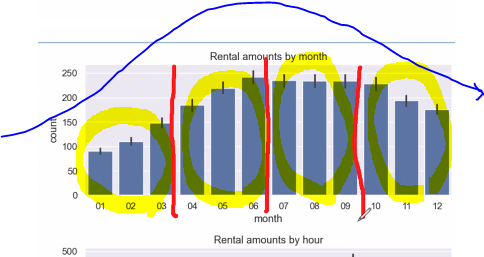

- year 차이가 검정을 안해도 차이가 보이죵~ 2011년도 2012년 대여량이 더 많음
- month 6,7,8 월 더운날 자전거 많이 타네 1월에 가장 적음
    - 날씨가 따뜻할수록 대여 수량이 많을 수 있음
      
- day 그래프를 보면 딱히 anova 검정 안해도 차이가없음을 알수있다
    - 테스트 세트에 day 가 다르기 때문에 없앰
      
- 새벽 4시에 가장 대여량이 적고 아침 8시와 저녁 5~6 시에 대여량이 가장 많음
- minute과 second는 0 데이터만 존재
    - 아무 정보 없기 때문에 제거

In [50]:
train_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date,year,month,day,hour,minute,second,weekday
0,2011-01-01 00:00:00,Spring,0,0,Clear,9.84,14.395,81,0.0,3,13,16,2011-01-01,2011,01,01,00,00,00,Saturday
1,2011-01-01 01:00:00,Spring,0,0,Clear,9.02,13.635,80,0.0,8,32,40,2011-01-01,2011,01,01,01,00,00,Saturday
2,2011-01-01 02:00:00,Spring,0,0,Clear,9.02,13.635,80,0.0,5,27,32,2011-01-01,2011,01,01,02,00,00,Saturday
3,2011-01-01 03:00:00,Spring,0,0,Clear,9.84,14.395,75,0.0,3,10,13,2011-01-01,2011,01,01,03,00,00,Saturday
4,2011-01-01 04:00:00,Spring,0,0,Clear,9.84,14.395,75,0.0,0,1,1,2011-01-01,2011,01,01,04,00,00,Saturday


# 범주형 데이터 시각화

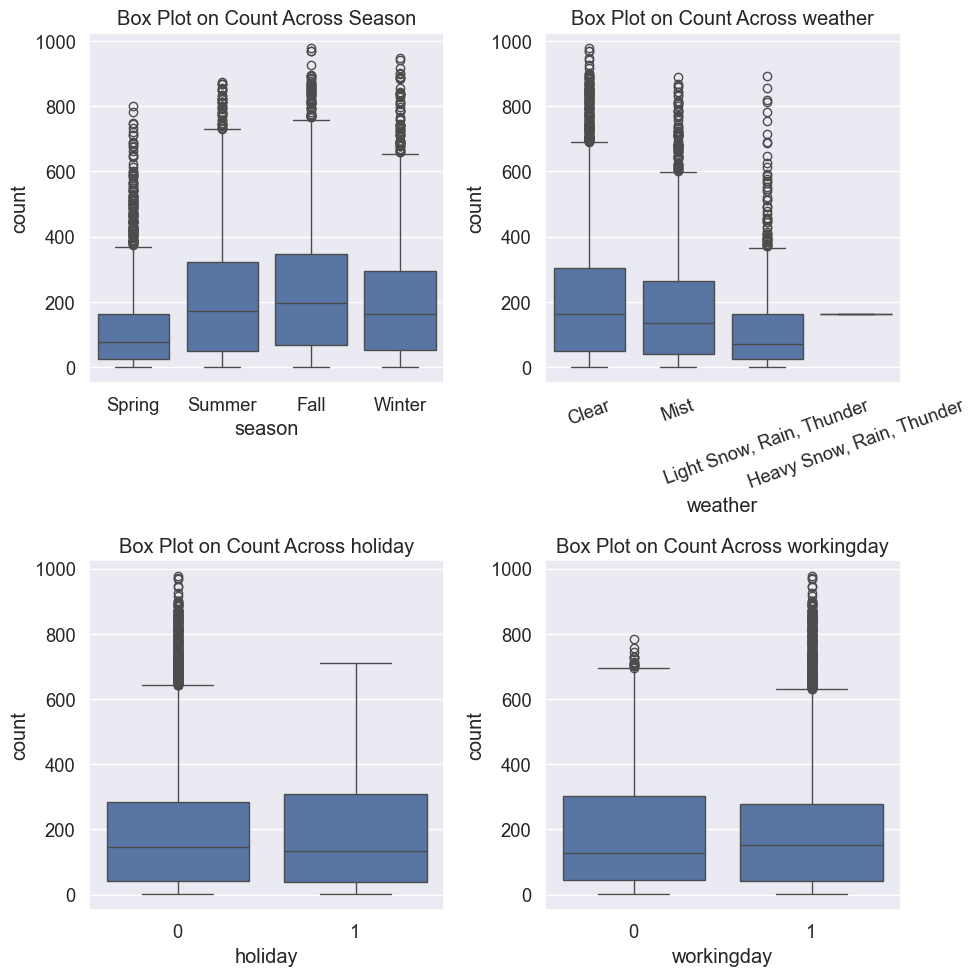

In [53]:
sns.set(font_scale = 1.2)
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (10,10))

sns.boxplot(x = "season",y = "count",data = train_df, ax = axes[0,0])
sns.boxplot(x = "weather",y = "count",data = train_df, ax = axes[0,1])
sns.boxplot(x = "holiday",y = "count",data = train_df, ax = axes[1,0])
sns.boxplot(x = "workingday",y = "count",data = train_df, ax = axes[1,1])

axes[0,0].set(title="Box Plot on Count Across Season")
axes[0,1].set(title="Box Plot on Count Across weather")
axes[1,0].set(title="Box Plot on Count Across holiday")
axes[1,1].set(title="Box Plot on Count Across workingday")


axes[0,1].tick_params("x", labelrotation = 20)

plt.tight_layout()
plt.show()

- 봄에 대여량이 가장 적고 가을에 가장 많음

- 날씨가 좋을 때 가장 대여량이 많고 날씨가 안좋아질수록 대여량이 적음

- 공휴일이 아닐 때와 공휴일일 때 대여량의 중앙값은 거의 비슷하지만 공휴일이 아닐 때는 이상치가 많음

- 근무일로 봐도 마찬가지로 근무일일 때 이상치가 많음

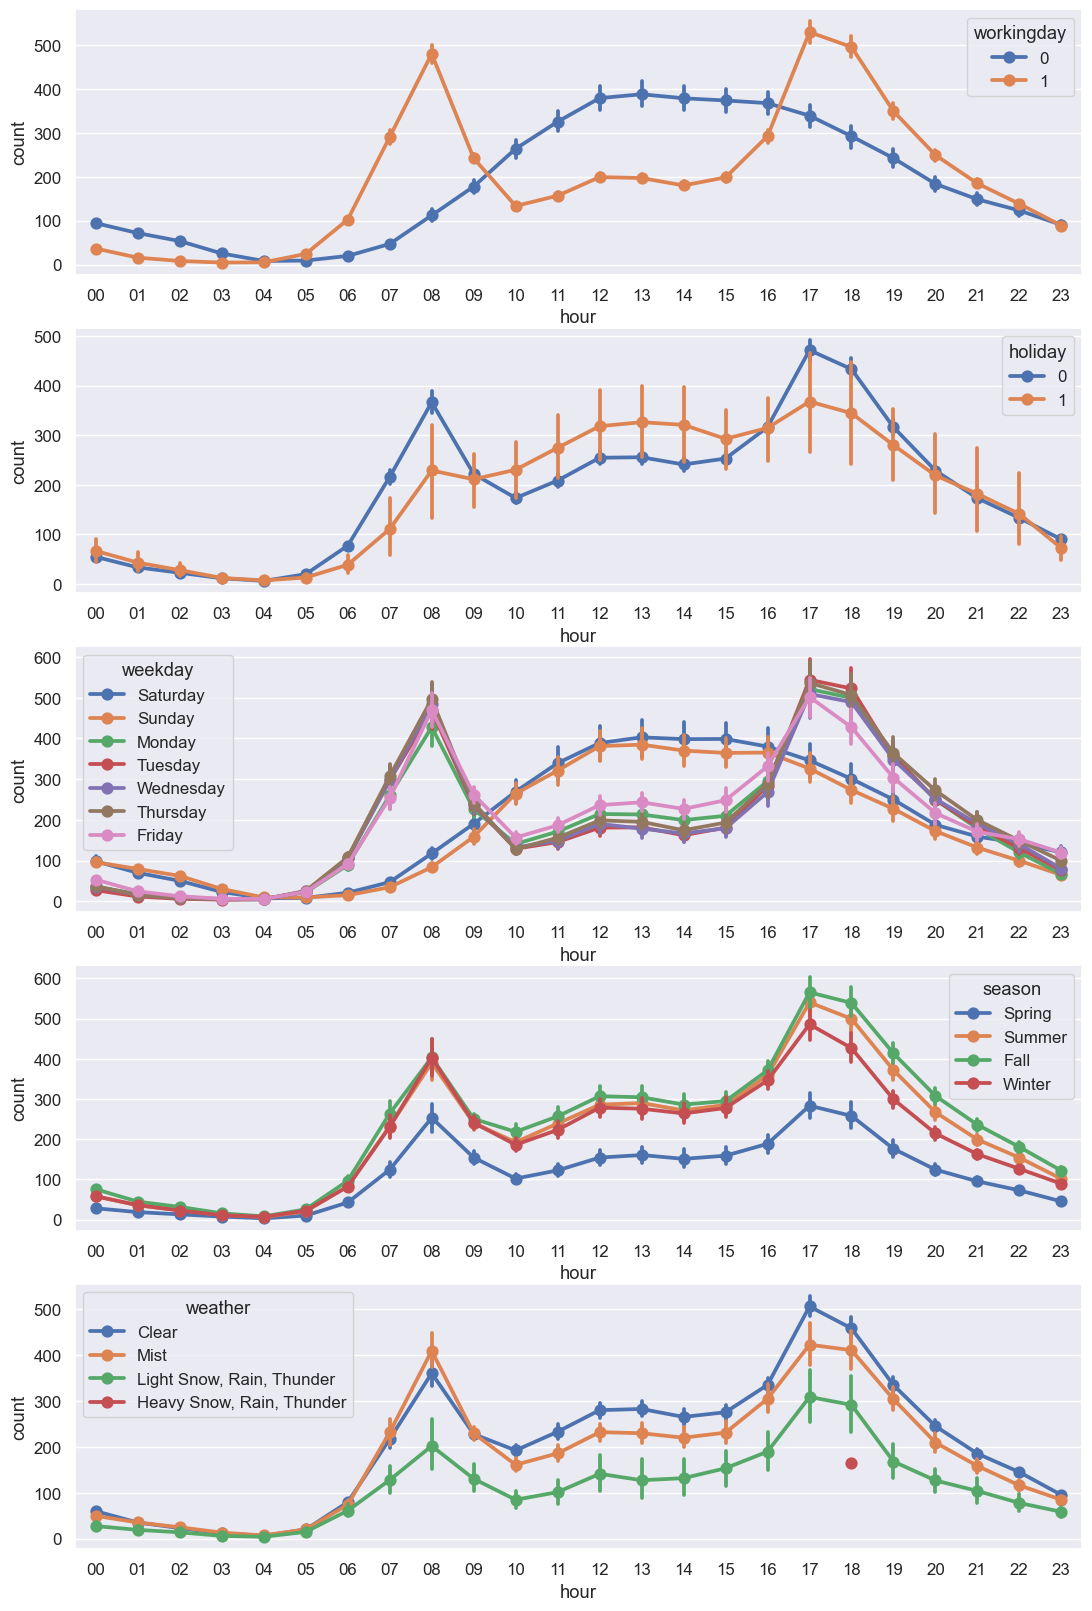

In [56]:
sns.set(font_scale = 1.1)
fig, axes = plt.subplots(nrows= 5, figsize = (13, 20))

# 근무일, 공휴일, 요일, 계절, 날씨에 따른 시간대별 평균 대여 수량 포인트 플롯
sns.pointplot(x = "hour", y= "count", data= train_df, hue = "workingday", ax = axes[0])
sns.pointplot(x = "hour", y= "count", data= train_df, hue = "holiday", ax = axes[1])
sns.pointplot(x = "hour", y= "count", data= train_df, hue = "weekday", ax = axes[2])
sns.pointplot(x = "hour", y= "count", data= train_df, hue = "season", ax = axes[3])
sns.pointplot(x = "hour", y= "count", data= train_df, hue = "weather", ax = axes[4])

plt.show()

- seaborn pointplot 의 신뢰구간이 참! 좋다!
- 신뢰구간이 넓으면 편차가 크다는 거니까 이상치가 많은것

- 6시 땡 하면 퇴근해라. 3등을 노려라

- 근무일에는 출퇴근 시간에 대여량이 많고 쉬는 날에는 오후 12~2시에 대여량이 많음

- 공휴일, 요일에 따른 그래프도 근무일 여부에 따른 그래프와 유사함

- 가을에 가장 대여량이 많고 봄에 가장 적음

- 날씨가 조을 때 가장 대여량이 많음
    - 폭우, 폭설이 내릴 때 저녁 6시에 대여건수가 있음
        - 이상치로 처리하는 것이 더 좋을 수 있음

### 날씨 데이터 시각화

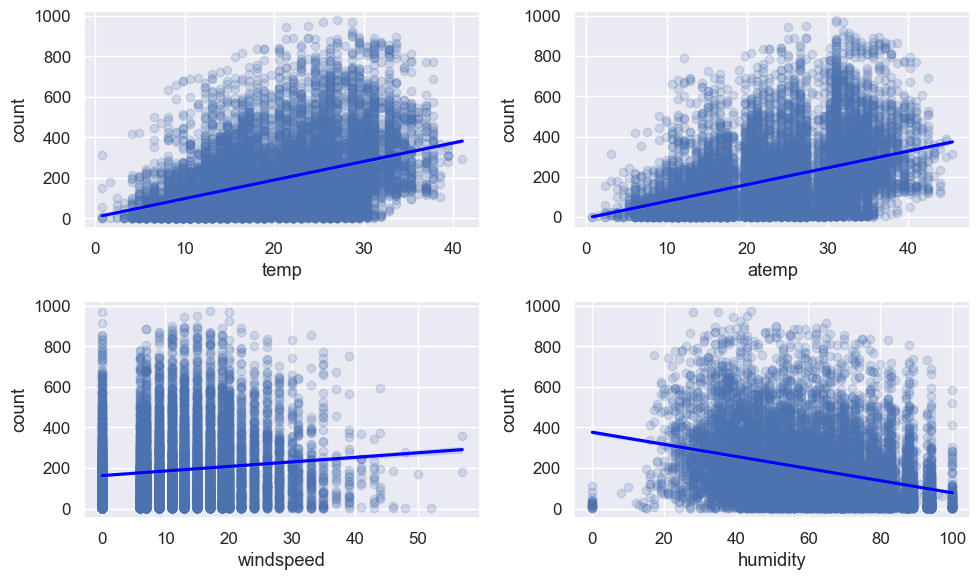

In [58]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (10,6))

# 온도, 체감 온도, 풍속, 습도 별 대여 수량 산점도 그래프
sns.regplot(x = "temp", y = "count", data = train_df, ax = axes[0,0], scatter_kws = {"alpha" : 0.2}, line_kws = {"color":"blue"})

sns.regplot(x = "atemp", y = "count", data = train_df, ax = axes[0,1], scatter_kws = {"alpha" : 0.2}, line_kws = {"color":"blue"})

sns.regplot(x = "windspeed", y = "count", data = train_df, ax = axes[1,0], scatter_kws = {"alpha" : 0.2}, line_kws = {"color":"blue"})

sns.regplot(x = "humidity", y = "count", data = train_df, ax = axes[1,1], scatter_kws = {"alpha" : 0.2}, line_kws = {"color":"blue"})

plt.tight_layout()
plt.show()

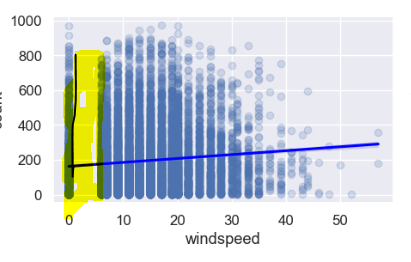

- 측정오류일 가능성이 너무 높져~~~

- 실제 온도와 체감 온도가 높을수록 대여량이 많음

- 습도가 낮을수록 대여량이 많음

- 풍속은 0인 데이터가 많고 풍속이 비어있는 구간이 있어 관측 오류가 의심됨
    - 이상값 대체를 하거나 컬럼 삭제를 고려해야함

### 히트맴

In [60]:
# 수치형 컬럼만 선택
corr_mat = train_df[["temp", "atemp", "humidity", "windspeed", "count"]].corr()

- windspeed 갈비다! 계륵이다!

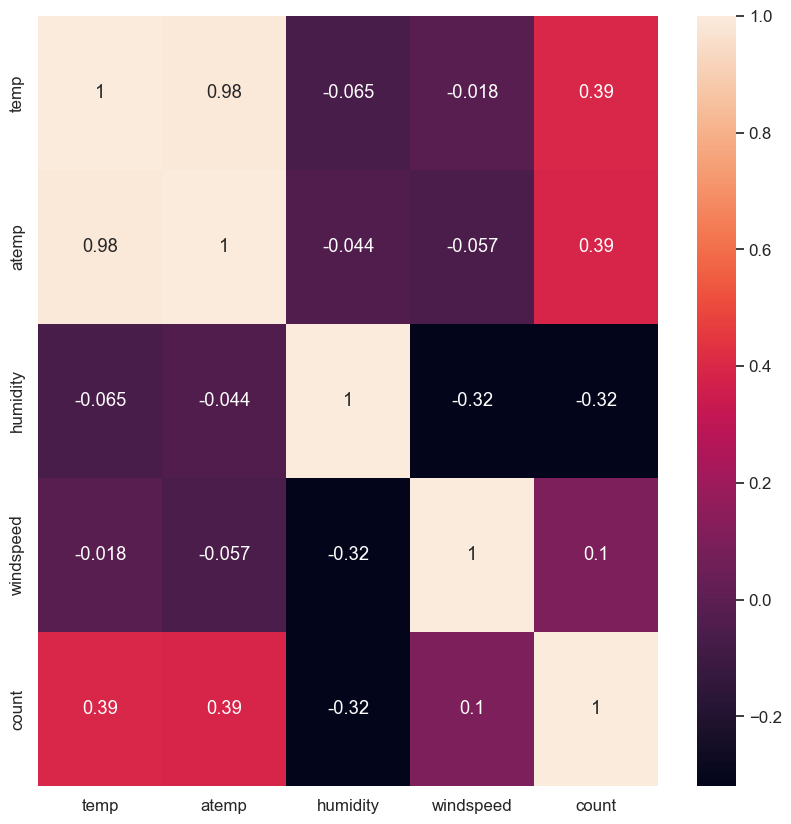

In [61]:
# 피처 간 상관관계
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corr_mat, annot = True)
plt.show()

- 풍속은 상관관계가 매우 약해서 모델 학습에 악영향을 줄 수 있음

## 정리

- 종속변수를 로그변환하여 정규분포에 가깝게 변환한 후 모델 학습

- datetime 컬럼은 여러 정보의혼합체이기 때문에 각각 연도, 월, 일 , 시간, 분, 초, 요일 컬럼으로 분리

- 테스트 데이터에 없는 casual 과 registered 는 삭제

- datetiem 은 인덱스 역할만 하기 때문에 삭제

- date 컬럼이 제공하는 정보는 정보는 모두 year, month ,day 로 분리했기 때문에 삭제

- month 는 season 의 세부 분류로 볼 수 있음
    - 데이터가 지나치게 세분화되면 분류별 데이터 수가 적어져 오히려 학습에 방해될 수 있어서 제거
 
- day는 분별력이 없어서 제거

- minute 과 second 는 아무런 정보가 없어서 제거

- weather 가 4인 경우는 이상치 처리

- windspeed 컬럼은 결측값이 많고 대여량과의 관계가 매우 약해서 제거

## 모델링 전략

- 베이스라인 모델 : 가장 기본적인 선형회귀 모델

- 타깃값은 log(count)사용

# 데이터 전처리

In [147]:
train_df = pd.read_csv("./data/bike/train.csv")
test_df = pd.read_csv("./data/bike/test.csv")
submission_df = pd.read_csv("./data/bike/sampleSubmission.csv")

In [148]:
# 정신나간 친구 제외
train_df = train_df[train_df["weather"] != 4]

In [149]:
# train 데이터와 test 데이터를 합쳐서 전처리 후
# 종속 변수가 null 인 데이터와 아닌 데이터로 나눈면 다시 train과 test로 나눠짐
all_df = pd.concat(
    [train_df, test_df] , ignore_index = True
)

In [150]:
all_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3.0,13.0,16.0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8.0,32.0,40.0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5.0,27.0,32.0
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3.0,10.0,13.0
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0.0,1.0,1.0


In [151]:
all_df.tail()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
17373,2012-12-31 19:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,NaN,NaN
17374,2012-12-31 20:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,NaN,NaN
17375,2012-12-31 21:00:00,1,0,1,1,10.66,12.880,60,11.0014,NaN,NaN,NaN
17376,2012-12-31 22:00:00,1,0,1,1,10.66,13.635,56,8.9981,NaN,NaN,NaN
17377,2012-12-31 23:00:00,1,0,1,1,10.66,13.635,65,8.9981,NaN,NaN,NaN


In [ ]:
all_df["date"] = all_df["datetime"].str.split().str[0]
all_df["year"] = all_df["date"].str.split("-").str[0]
all_df["month"] = all_df["date"].str.split("-").str[1]
all_df["hour"] = all_df["datetime"].str.split().str[1].str.split(":").str[0]
all_df["weekend"] = all_df["date"].map(lambda x: pd.to_datetime(x).weekday())

In [153]:
all_df = all_df.drop(["datetime","casual","registered","date","month","windspeed","weekend"],axis=1)

In [154]:
all_df.head(1)

,season,holiday,workingday,weather,temp,atemp,humidity,count,year,hour
0,1,0,0,1,9.84,14.395,81,16.0,2011,00


In [155]:
train = all_df[~pd.isna(all_df["count"])]
test = all_df[pd.isna(all_df["count"])]

In [156]:
x_train = train.drop("count", axis = 1)
x_test = test.drop("count", axis = 1)
y = train["count"]

In [157]:
x_train.shape,x_test.shape,y.shape

((10885, 9), (6493, 9), (10885,))

# 베이스라인 모델

In [158]:
lr_l = LinearRegression()
log_y = np.log(y)
lr_l.fit(x_train, log_y)

LinearRegression()

In [159]:
lr_n = LinearRegression()
lr_n.fit(x_train, y)

LinearRegression()

In [161]:
pred_l = lr_l.predict(x_train)
pred_n = lr_n.predict(x_train)

In [168]:
print(rmsle(log_y, pred_l, True))

1.0210263602962202


In [175]:
print(rmsle(y, pred_n, False))

1.2925482607132543


C:\Users\ITSC\AppData\Local\Temp\ipykernel_2792\3723117015.py:14: RuntimeWarning: invalid value encountered in log
  log_pred = np.nan_to_num(np.log(y_pred + 1))


In [170]:
pred = lr_l.predict(x_test)
pred = np.exp(pred)
submission_df["count"] = pred

In [173]:
submission_df.to_csv("submission_test강사님.csv", index = False)

In [174]:
submission_df.head()

,datetime,count
0,2011-01-20 00:00:00,11.112781
1,2011-01-20 01:00:00,13.244981
2,2011-01-20 02:00:00,14.687804
3,2011-01-20 03:00:00,15.901731
4,2011-01-20 04:00:00,17.633964


- test_score : 1.02142